Step 1 : Load, label and combine the dataset

In [3]:
import pandas as pd
true_df = pd.read_csv("C:/Users/User/Downloads/True.csv")
fake_df = pd.read_csv("C:/Users/User/Downloads/Fake.csv")
true_df['label'] = 1
fake_df['label'] = 0
combined_df = pd.concat([true_df, fake_df], ignore_index=True)
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)
print("Class Distribution:\n", combined_df['label'].value_counts())


Class Distribution:
 label
0    23481
1    21417
Name: count, dtype: int64


Step 2 : Clean the text data

In [5]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text
combined_df['clean_text'] = combined_df['text'].astype(str).apply(clean_text)
print("\nSample Cleaned Text:\n")
print(combined_df[['clean_text', 'label']].head())



Sample Cleaned Text:

                                          clean_text  label
0  donald trump s white house is in chaos and the...      0
1  now that donald trump is the presumptive gop n...      0
2  mike pence is a huge homophobe he supports exg...      0
3  san francisco reuters california attorney gene...      1
4  twisted reasoning is all that comes from pelos...      0


Step 3 : Split train and test data

In [6]:
from sklearn.model_selection import train_test_split

X = combined_df['clean_text'].values
y = combined_df['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nStep 3: Dataset Split")
print("Training samples:", len(X_train))
print("Testing samples :", len(X_test))



Step 3: Dataset Split
Training samples: 35918
Testing samples : 8980


Step 4 : Tokenization and padding

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
max_len = 500
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

print("\nStep 4: Tokenization and Padding Done")
print("Example padded sequence:\n", X_train_pad[0])



Step 4: Tokenization and Padding Done
Example padded sequence:
 [2787   67 1939 1642    1 7510    1  847  224   26    2   86  395  291
  267    9  216   21 3248    2  446  121  545    6 1011  291   10  968
   20   74   42  258 2296  577    2  108 5178  450  232   30  361    9
    3 5348  215 1233    7    1    6  108    1   14    7  609   51   18
 7762   26    2  446  831    4 3285    9  291   92    4    5 1213    4
  126 1759 9491    1    3    2  446  412  219  545   50  397   65    2
  831    4 3285  695  115  504 7510    1   14   51   42 2953   58    4
 4345   36   84   25 3229   26    2  285  436    6    2  121  545    5
 1447 1339    7  307    5 5717   31 1736    1 5717   11   57    2 1233
    8   29 1060    7  291   51   14  979  115    4  780    7  291    6
  916 8620    8   12   25 4298 7510    1   85    5 5178 1243   96  268
  440  461 7405    3    1   38 2937 3412    4  215 1233   52 2911 2386
  102   98 2250 8684    4    2 3285 6198    1    1    6    2  574    1
    1   30  

Step 5 : Build the model

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
model = Sequential([
    Embedding(input_dim=10000, output_dim=64),  
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, max_len))
print("\nModel Built and Compiled")
model.summary()



Model Built and Compiled


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 500, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 675,137 (2.58 MB)

 Trainable params: 675,137 (2.58 MB)

 Non-trainable params: 0 (0.00 B)

Step 6 : Train the model and visualise metrics

Epoch 1/5
281/281 ━━━━━━━━━━━━━━━━━━━━ 148s 527ms/step - accuracy: 0.9336 - loss: 0.2295 - val_accuracy: 0.6640 - val_loss: 0.5037
Epoch 2/5
281/281 ━━━━━━━━━━━━━━━━━━━━ 146s 518ms/step - accuracy: 0.6743 - loss: 0.5082 - val_accuracy: 0.5925 - val_loss: 0.5847
Epoch 3/5
281/281 ━━━━━━━━━━━━━━━━━━━━ 195s 494ms/step - accuracy: 0.6359 - loss: 0.5510 - val_accuracy: 0.9276 - val_loss: 0.3356
Epoch 4/5
281/281 ━━━━━━━━━━━━━━━━━━━━ 145s 503ms/step - accuracy: 0.8832 - loss: 0.3148 - val_accuracy: 0.9526 - val_loss: 0.1402
Epoch 5/5
281/281 ━━━━━━━━━━━━━━━━━━━━ 140s 499ms/step - accuracy: 0.9578 - loss: 0.1417 - val_accuracy: 0.9795 - val_loss: 0.0767


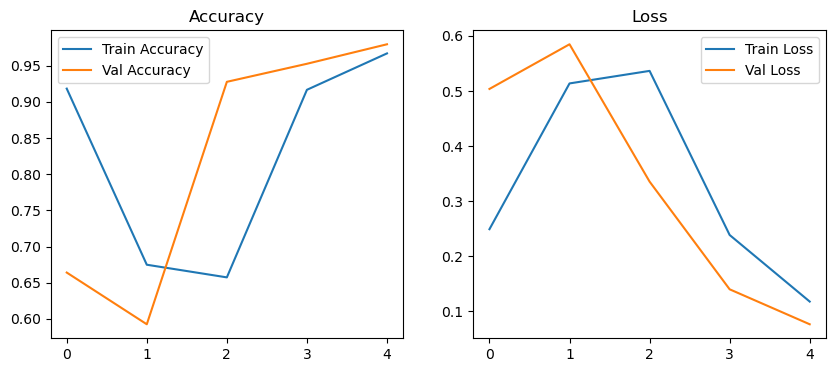


Model Training Completed and Metrics Visualized


In [14]:
import matplotlib.pyplot as plt

history = model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test),
                    epochs=5, batch_size=128)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.legend()
plt.title("Loss")
plt.show()

print("\nModel Training Completed and Metrics Visualized")


Step 7 : Evaluate and interpret prediction

In [16]:
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f"\nStep 7: Model Evaluation\nTest Accuracy: {accuracy:.4f}\nTest Loss: {loss:.4f}")
predictions = model.predict(X_test_pad[:5])
predicted_labels = (predictions > 0.5).astype(int).flatten()

print("\nSample Predictions:")
for i in range(5):
    print(f"\nText: {X_test[i][:100]}...")
    print(f"Actual Label   : {y_test[i]}")
    print(f"Predicted Label: {predicted_labels[i]}")


281/281 ━━━━━━━━━━━━━━━━━━━━ 19s 66ms/step - accuracy: 0.9801 - loss: 0.0777

Step 7: Model Evaluation
Test Accuracy: 0.9795
Test Loss: 0.0767
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step

Sample Predictions:

Text: washington reuters us state department investigators last year issued a subpoena to the bill hillary...
Actual Label   : 1
Predicted Label: 1

Text: ankara reuters the breakup of either iraq or syria could lead to global conflict turkey s defense mi...
Actual Label   : 1
Predicted Label: 1

Text: outspoken british actress and columnist asks brilliant question any mosques lit up in the colors of ...
Actual Label   : 0
Predicted Label: 0

Text: toronto reuters the name trump will be removed from a highrise hotel and condo development in downto...
Actual Label   : 1
Predicted Label: 1

Text: abuja reuters the united states has formally agreed to sell super tucano a planes and weapons to nig...
Actual Label   : 1
Predicted Label: 1
